In [1]:
import time
import gensim
import jieba
import jieba.analyse
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1.训练word2vec模型

#### 打开语料库文件准备word2vec训练

In [2]:
with open('corpus_weibo.txt', 'rb') as fin:
    corpus_list = fin.read().decode('utf-8').splitlines()

#### 利用结巴分词对语料库进行分词

In [3]:
time1 = time.time()
lines = [jieba.lcut(corpus) for corpus in corpus_list]
print('分词时间 %f s' % (time.time() - time1))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Weitang\AppData\Local\Temp\jieba.cache
Loading model cost 1.050 seconds.
Prefix dict has been built succesfully.


分词时间 45.677973 s


#### 查看一个分词结果

In [4]:
'/'.join(lines[-1])

'【/国务院参事/牛文元/：/中国/去年/日均/500/起/群体/事件/】/牛文元/：/去年/，/广东/发生/了/乌坎/事件/。/实际上/，/2011/年/，/中国/平均/每天/发生/500/起/群体性/事件/，/这/意味着/，/现今/社会/容易/失序/，/民众/心理/容易/失调/，/效率/和/公平/需要/不断/协调/和/重建/。'

#### 训练word2vec模型

In [5]:
time1 = time.time()
m = gensim.models.Word2Vec(lines)
print('word2vec模型训练时间 %f s' % (time.time() - time1))

word2vec模型训练时间 21.668325 s


## 2.分析与中国有关的微博语料，获取主题词及其词向量

#### 打开与中国有关的微博语料文件

In [6]:
with open('target_weibo.txt', 'rb') as fin:
    target_text = fin.read().decode('utf-8')

#### 利用TF-IDF构建语料主题词
`allowPOS`参数对词性进行了限制，以下是比较常用的几个：
* ns 地名
* n 名词
* vn 名动词
* v 动词

更多与词性有关的资料，请查看http://blog.csdn.net/kevin_darkelf/article/details/39520881

In [7]:
kw_list = jieba.analyse.extract_tags(target_text, topK=500, withWeight=True, allowPOS=['n', 'v', 'nr', 'ns', 'vn', 'a', 'l'])

#### 查看权重最大的10个主题词，主题词总数为500个，由`topK`参数确定

In [8]:
kw_list[:10]

[('中国', 0.1427278899238232),
 ('城管', 0.02797041429367398),
 ('吴英', 0.0253184069754981),
 ('国家', 0.02144154788818793),
 ('经济', 0.02136949955277585),
 ('社会', 0.021283590764639558),
 ('没有', 0.019067521308772786),
 ('美国', 0.019028127349534234),
 ('政府', 0.01764197201552124),
 ('问题', 0.017627668987355457)]

#### 将列表转化为`pandas series`

In [9]:
kw_weight = pd.Series({k:v for k,v in kw_list}, name='weight')
kw_weight.head()

上学    0.004514
上海    0.003211
不会    0.004528
不公    0.002287
不到    0.002347
Name: weight, dtype: float64

In [10]:
kw_weight.describe()

count    500.000000
mean       0.004534
std        0.006908
min        0.002175
25%        0.002620
50%        0.003292
75%        0.004676
max        0.142728
Name: weight, dtype: float64

#### 依据训练的word2vec模型，将主题词转化为100维的词向量。可能少数关键词word2vec模型没有训练到，需要剔除。

In [11]:
kw_vector = pd.DataFrame({k:m.wv[k] for k,v in kw_list if k in m.wv}).transpose()
kw_vector.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
上学,-1.128589,-0.367355,-0.096248,0.915308,0.479002,-1.151313,-2.295656,0.920987,-1.445959,-0.533657,...,-1.389900,-0.331633,0.406455,-0.542418,0.123502,0.730157,0.045659,-0.020402,-0.609132,-1.083153
上海,0.764387,-0.467646,-1.024570,1.707964,0.534062,-0.596795,-1.062196,-0.043051,-0.234849,-0.318463,...,0.363182,0.455008,1.247220,-0.040647,0.442148,-0.527718,-1.276886,-0.152042,-0.916437,-0.836824
不会,0.181139,-0.325231,-0.048768,1.275730,0.282924,0.223610,1.484118,-1.523503,-0.306456,-0.084269,...,-2.279715,-0.705629,-0.109858,2.033981,2.053800,-0.025513,-2.010319,-1.385831,2.195823,0.962219
不公,-0.095527,0.731906,0.159449,-0.556952,0.314904,-0.377853,0.047670,-0.899250,-0.717997,-0.042025,...,-0.028409,1.083843,-0.564895,0.107429,0.602555,0.609575,-0.247174,-0.578400,-0.133504,-0.036293
不到,-2.341919,-1.087403,-0.803212,0.705790,0.322900,-0.015272,0.530963,-1.297981,1.368198,-1.022712,...,-2.499300,-0.881470,-1.008060,1.406718,1.471646,1.651625,-2.563403,0.264345,0.835758,-0.777004


#### 词向量当前没有归一化，一般采用余弦相似度表示两个词向量之间的相似度。

In [12]:
kw_vector.transpose().describe()

,上学,上海,不会,不公,不到,不卖,不同,不求人,不畏,不能,...,韩寒,韩方,项目,领域,领导,食品,食品安全,香港,马其顿,高铁
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.117127,0.031005,-0.013605,-0.025024,-0.164246,-0.003273,0.019313,-0.082098,-0.019485,0.019716,...,0.019308,0.030518,-0.035906,0.060687,0.114267,-0.014580,-0.010102,0.100362,0.061135,0.019881
std,0.898615,0.963687,1.467811,0.626680,1.104676,0.107398,1.106059,0.719092,0.733107,1.482273,...,0.636365,0.275131,0.973273,1.038210,1.446187,1.228052,0.460594,1.366608,0.502520,0.740900
min,-2.295656,-1.946101,-3.557197,-1.347950,-2.563403,-0.255723,-2.430381,-1.908481,-1.474626,-3.136859,...,-1.614125,-0.609135,-2.313949,-2.523249,-2.904240,-2.975263,-1.206310,-2.854692,-1.067050,-1.844117
25%,-0.639588,-0.644107,-1.070235,-0.539628,-0.939040,-0.078085,-0.721426,-0.492861,-0.595295,-1.065599,...,-0.474235,-0.168986,-0.704466,-0.631616,-1.017594,-0.875451,-0.296422,-0.707990,-0.290280,-0.394157
50%,-0.130334,-0.141888,-0.014431,-0.027974,-0.239660,-0.006857,-0.035274,-0.136303,-0.115190,0.106563,...,-0.003110,-0.006804,-0.008862,0.142050,0.160570,0.071647,-0.016383,0.038476,0.019944,0.035340
75%,0.450681,0.647757,0.975202,0.409401,0.692597,0.057135,0.753636,0.351543,0.372896,0.926487,...,0.444830,0.218832,0.663183,0.700831,1.286620,0.894867,0.336373,1.082194,0.416110,0.531433
max,1.737006,2.291597,3.985549,1.536524,2.096804,0.279776,2.549959,1.949883,2.577029,3.698512,...,1.850765,0.655047,2.272986,2.777908,3.073766,2.434186,1.025735,3.546632,1.150768,1.693953


#### 之后进行降维时距离度量不支持余弦相似度，这里对词向量进行归一化，之后用欧氏距离表示词向量之间的相似度。

In [13]:
n_kw_vector = kw_vector.div(kw_vector.std(axis=1), axis=0)
n_kw_vector.transpose().describe()

,上学,上海,不会,不公,不到,不卖,不同,不求人,不畏,不能,...,韩寒,韩方,项目,领域,领导,食品,食品安全,香港,马其顿,高铁
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.130341,0.032174,-0.009269,-0.039931,-0.148682,-0.030476,0.017461,-0.114169,-0.026579,0.013301,...,0.030341,0.110923,-0.036892,0.058454,0.079012,-0.011872,-0.021933,0.073439,0.121656,0.026833
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,-2.554659,-2.019433,-2.423470,-2.150940,-2.320502,-2.381086,-2.197334,-2.654016,-2.011475,-2.116249,...,-2.536474,-2.213982,-2.377492,-2.430384,-2.008204,-2.422749,-2.619033,-2.088889,-2.123400,-2.489023
25%,-0.711748,-0.668378,-0.729137,-0.861090,-0.850059,-0.727066,-0.652249,-0.685394,-0.812017,-0.718895,...,-0.745225,-0.614201,-0.723811,-0.608370,-0.703639,-0.712878,-0.643565,-0.518064,-0.577650,-0.531997
50%,-0.145038,-0.147235,-0.009831,-0.044638,-0.216950,-0.063844,-0.031892,-0.189549,-0.157126,0.071892,...,-0.004888,-0.024728,-0.009105,0.136822,0.111030,0.058342,-0.035569,0.028154,0.039687,0.047699
75%,0.501528,0.672165,0.664392,0.653286,0.626968,0.531996,0.681371,0.488870,0.508651,0.625045,...,0.699017,0.795371,0.681394,0.675038,0.889663,0.728688,0.730304,0.791884,0.828047,0.717281
max,1.932980,2.377949,2.715300,2.451850,1.898117,2.605049,2.305445,2.711592,3.515216,2.495162,...,2.908336,2.380852,2.335404,2.675671,2.125427,1.982152,2.226984,2.595208,2.289997,2.286345


#### 有时训练的word2vec模型没有我们提取的关键词，从权重`Series`中剔除这部分关键词

In [14]:
filtered_kw_weight = kw_weight[n_kw_vector.index]
len(filtered_kw_weight)

499

#### 利用AgglomerativeClustering对关键词进行层次聚类

In [15]:
ac = AgglomerativeClustering(30)
ac.fit(kw_vector)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=30,
            pooling_func=<function mean at 0x0000024EFFF8D158>)

#### 利用聚类结果，给关键词打上标签，标签相同的是一类

In [16]:
kw_label = pd.Series(ac.labels_, index=kw_vector.index, name='label')
kw_label.head()

上学    21
上海     7
不会     9
不公     6
不到     4
Name: label, dtype: int64

#### 展示不同类的关键词

In [17]:
for group in kw_label.groupby(kw_label.values):
    print(list(group[1].index))

['专业', '世界', '产业', '人类', '伟大', '传统', '体系', '健康', '全面', '创新', '力量', '历史', '和谐', '基础', '学习', '实现', '市场经济', '幸福', '建立', '强大', '思想', '成为', '成功', '推动', '政治', '文化', '文明', '时代', '梦想', '模式', '民主', '民族', '法治', '特色', '生命', '生态', '生活', '社会主义', '科技', '秩序', '精神', '自由', '计算', '财富', '道德', '重要']
['专家', '主题', '代表', '作为', '参与', '反腐败', '发表', '合作', '呼吁', '国际', '委员会', '学者', '建议', '强调', '意见', '批评', '指出', '接受', '提出', '支持', '文章', '研究', '科学', '表示', '要求', '观点', '言论', '认为', '讨论', '评价', '评论', '说法']
['严重', '事故', '出现', '发生', '导致', '引发', '校车', '死亡', '造成']
['作家', '先生', '同志', '回复', '微博', '教授', '新闻', '方舟子', '演员', '演讲', '电影', '电脑', '电视', '直播', '节目', '观察报', '论坛', '财经', '贺卫方', '转发', '采访', '韩寒']
['不到', '不能', '事实', '伤害', '值得', '关键', '反思', '变成', '只能', '失去', '宽容', '带来', '应该', '心理', '思考', '想象', '意义', '意味着', '感觉', '才能', '担心', '挑战', '改变', '无法', '机会', '根本', '现实', '相信', '肯定', '能够', '说明', '起来', '选择', '逻辑', '错误', '需要', '面对']
['举行', '会议', '全国', '公布', '北京', '参加', '发布', '年度', '成立', '报告', '显示', '联合']
['不公', '不卖', '乌坎', '产权', '人民网', '任志强

## 利用T-SNE对词向量降维可视化，制作词云

#### 使用T-SNE将词向量映射到2维

In [18]:
tsne = TSNE()
kw_tsne_v = tsne.fit_transform(n_kw_vector)

#### 将`Array`格式二维词向量转化为`DataFrame`

In [19]:
kw_tsne_df = pd.DataFrame(kw_tsne_v, index=n_kw_vector.index, columns=['x', 'y'])
kw_tsne_df.head()

,x,y
上学,22.688578,7.831987
上海,21.034611,-11.886078
不会,-26.912733,14.565060
不公,-12.043228,4.991376
不到,-28.313391,11.690903


In [20]:
kw_tsne_df.describe()

,x,y
count,499.000000,499.000000
mean,0.933057,-0.027351
std,16.512474,8.902691
min,-30.329882,-18.214689
25%,-13.914374,-7.371433
50%,-0.002028,0.238714
75%,15.084167,6.511093
max,33.601379,20.218811


#### 大致观察降维结果

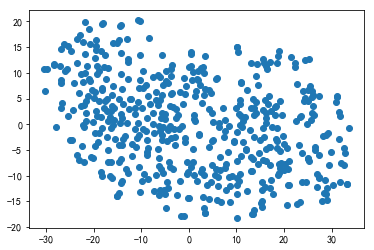

In [21]:
plt.scatter(kw_tsne_df['x'], kw_tsne_df['y']); plt.show()

#### 将关键词的标签、降维后的xy坐标、权重汇总到一个`DataFrame`中

In [22]:
kw_df = pd.concat([kw_label, kw_tsne_df, filtered_kw_weight], axis=1)
kw_df.head()

,label,x,y,weight
上学,21,22.688578,7.831987,0.004514
上海,7,21.034611,-11.886078,0.003211
不会,9,-26.912733,14.565060,0.004528
不公,6,-12.043228,4.991376,0.002287
不到,4,-28.313391,11.690903,0.002347


In [23]:
kw_df.describe()

,label,x,y,weight
count,499.000000,499.000000,499.000000,499.000000
mean,9.725451,0.933057,-0.027351,0.004539
std,8.268509,16.512474,8.902691,0.006914
min,0.000000,-30.329882,-18.214689,0.002175
25%,4.000000,-13.914374,-7.371433,0.002623
50%,6.000000,-0.002028,0.238714,0.003293
75%,17.000000,15.084167,6.511093,0.004678
max,29.000000,33.601379,20.218811,0.142728


#### 利用`matplotlib`绘制词云。相对位置为词之关键词间的关联度，颜色为关键词类，大小为关键词权重（的1/2次方）。
如果matplotlib出现中文乱码问题，参考https://www.zhihu.com/question/25404709

In [24]:
plt.figure(figsize=(18,18))
axis = plt.subplot(111)
plt.axis('off')
axis.scatter(kw_df['x'], kw_df['y'], s=np.sqrt(kw_df['weight']) * 3000, alpha=0.6, c=kw_df['label'], cmap='jet')
axis.set_title('与“中国”有关的微博中出现的关键词')
for index, row in kw_df.iterrows():
    axis.annotate('%d%s' % (row['label'], index), (row['x'], row['y']), alpha=0.8)

#### 保存词云图片

In [25]:
plt.savefig('kw_cloud.png', dpi=200)

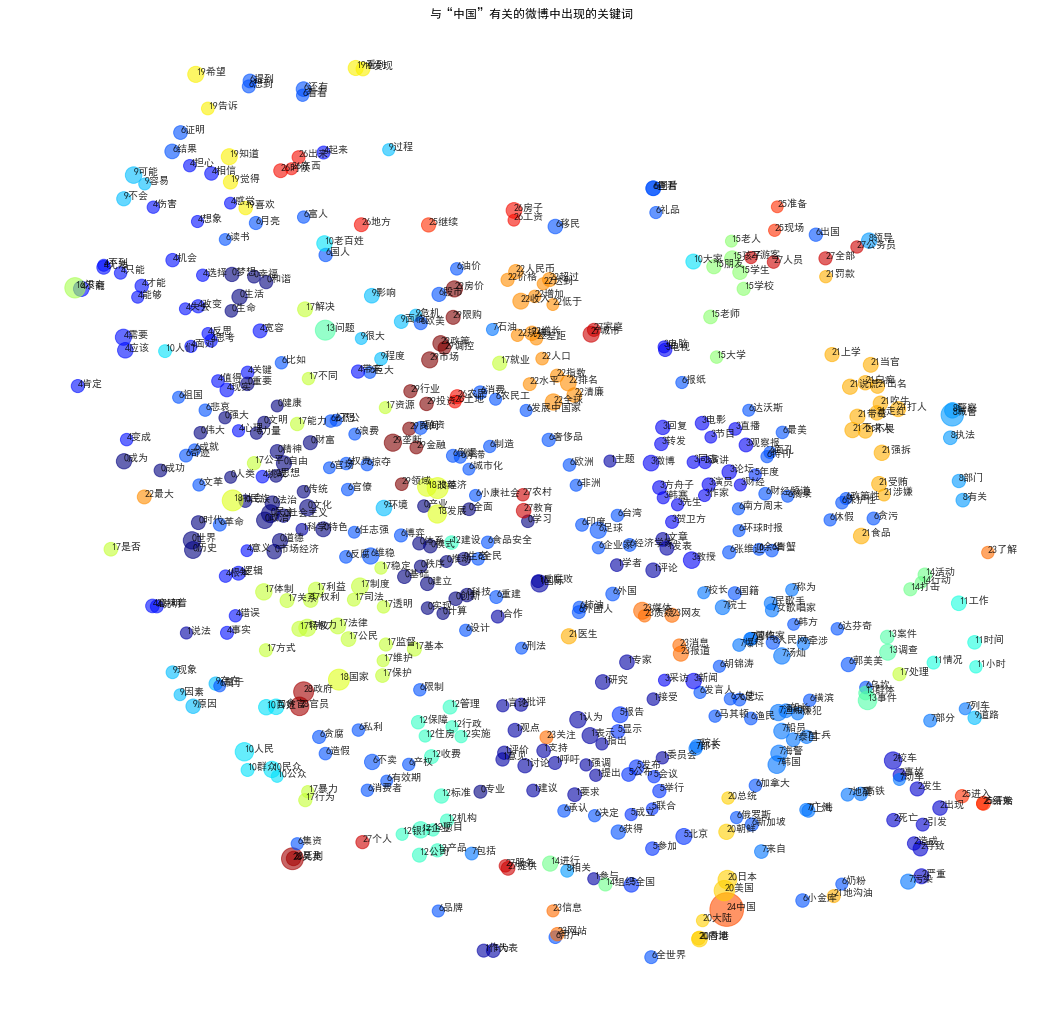

In [26]:
plt.show()